# Satellite image forecasting demo

This is a demo to quickly visualize the time step, and the prediction yielded by the model. You will be able to directly run our trained models here and check out the predictions they yield.

In [1]:
os.chdir("..") # You should now be in the 'drought_impact_forecasting' folder
os.getcwd()

'c:\\Users\\otomr\\OneDrive\\Documents\\GitHub\\drought_impact_forecasting'

In [2]:
import sys
import os
import numpy as np
from matplotlib import gridspec
import datetime as dt

sys.path.append(os.getcwd())

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is very fine, but slower

from load_model_data import load_data_point, load_model
from draw_forecast import visualize_rgb
from time_ndvi_plot import plot_ndvi

### Loading data

In the following, the data will be loaded. In order for this to work, we recommend cloning the whole repository to have easy access to small_data: a small section of the dataset usefull for experiments.

Now we can load a specific datapoint with the load_data_point function. We can either load from a test set, and then we need both context and target, or from a training set, and then it's all in one file. To understand the difference between the various dataset components look at https://arxiv.org/pdf/2104.10066.pdf. Use a different value of index, allows to look at different images in the same dataset. 

Here truth is the whole datacube. Context and Target are as described in our paper, and npf (non predicted features) are the meteorological variables in the Target.

In [3]:
# from test set
truth, context, target, npf = load_data_point(test_context_dataset = "Data/small_data/extreme_context_data_paths.pkl", 
                                              test_target_dataset = "Data/small_data/extreme_target_data_paths.pkl",
                                              index = 0)

# from train set
#truth, context, target, npf = load_data_point(train_dataset= "Data/small_data/train_data_paths.pkl",
#                                              index = 0)

### Loading models
Here we load the two models presented in our paper

In [4]:
# Loading models from checkpoints
SGConvLSTM = load_model("trained_models/SGConvLSTM.ckpt")
SGEDConvLSTM = load_model("trained_models/SGEDConvLSTM.ckpt")

### Inference
Here we run our models on the loaded datapoint.

Since in npf is encoded data about weather, one can modify it to see the effect of different weathers in our forecast. npf is in R^[1 x channel x height x width x time]. The channels are in the following order: 0 - elevation map. 1 - precipitation. 2-3-4 - min/mean/max temperature. - 5 pressure. For the units and further infors look at https://www.earthnet.tech/docs/ds-specifications/

In [5]:
# Running inference: it can be slow. 
SGConvLSTM_prediction, _, _ = SGConvLSTM(x = context, 
                    prediction_count = int((2/3)*truth.shape[-1]), 
                    non_pred_feat = npf)
SGEDConvLSTM_prediction, _, _ = SGEDConvLSTM(x = context, 
                    prediction_count = int((2/3)*truth.shape[-1]), 
                    non_pred_feat = npf)

### Graphics
To get a sensible idea of what our model is doing, we propose two graphs. In the first one can see the evolution through time, and the forecasted image side by side. In the second graphic, one can see the median NDVI evolution over time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


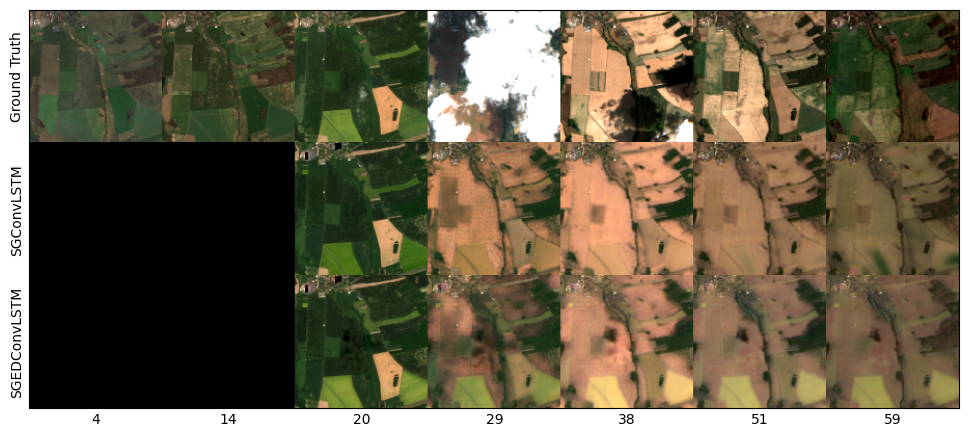

In [6]:
visualize_rgb([SGConvLSTM_prediction,SGEDConvLSTM_prediction],
                truth,
                labels = ["SGConvLSTM", "SGEDConvLSTM"],
                undersample_indexs=[4,14,20,29,38,51,59])

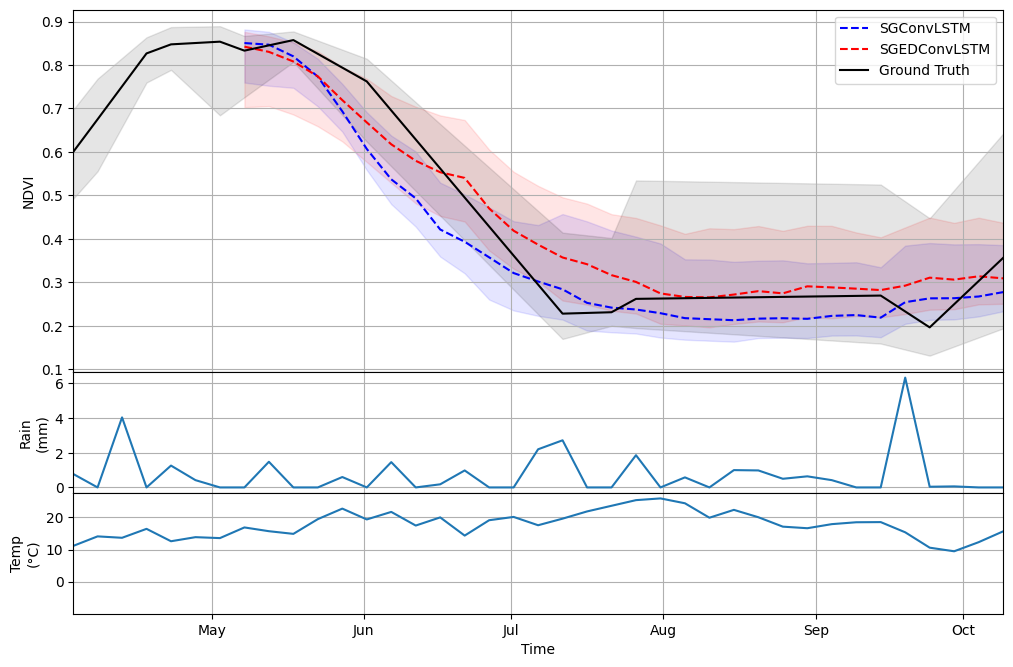

In [9]:
plot_ndvi(truth = truth, 
            preds = [SGConvLSTM_prediction,SGEDConvLSTM_prediction], 
            dates_bound = ['2018-01-28', '2018-11-23'], 
            model_names=["SGConvLSTM", "SGEDConvLSTM"], 
            filename = None,
            prec_temp = True)